# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import nltk
import spacy
import re
import sklearn.metrics as metrics
import torch

from tqdm.auto import tqdm
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.metrics import f1_score, precision_recall_curve, accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier 

import warnings # ignore warnings
warnings.filterwarnings("ignore")

In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.1 MB/s eta 0:00:00


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [5]:
df_reviews = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.head(3)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [13]:
#revisión de duplicados en el dataframe
df_reviews.duplicated().sum()

0

In [14]:
#revisión de los valores del target
df_reviews["pos"].unique()

array([0, 1])

In [15]:
#revisión de la columna "ds_part"
df_reviews["ds_part"].unique()

array(['train', 'test'], dtype=object)

In [16]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


La base de datos muestra:
1. Hay 47331 registros, con 17 columnas, las cuales son del tipo object, int, float.
2. Las columnas de interés son: "reviews", "pos" y "ds_part", ninguna de las 3 tiene datos ausentes. "Reviews" es del tipo object, el target: "pos" es int y "ds_part" es object.
3. Se detectaron 2 datos ausentes en las columnas average_rating y votes.
4. No hay datos duplicados.
5. La columna "start_year" muestra un mínimo de 1894, dato curioso por lo antiguo de esa película.
6. La columna "pos" tiene una media muy por encima de la mediana, es decir hay una asimetría positiva.
7. Casi todas las películas están dentro de la clasificación de no adultos.

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

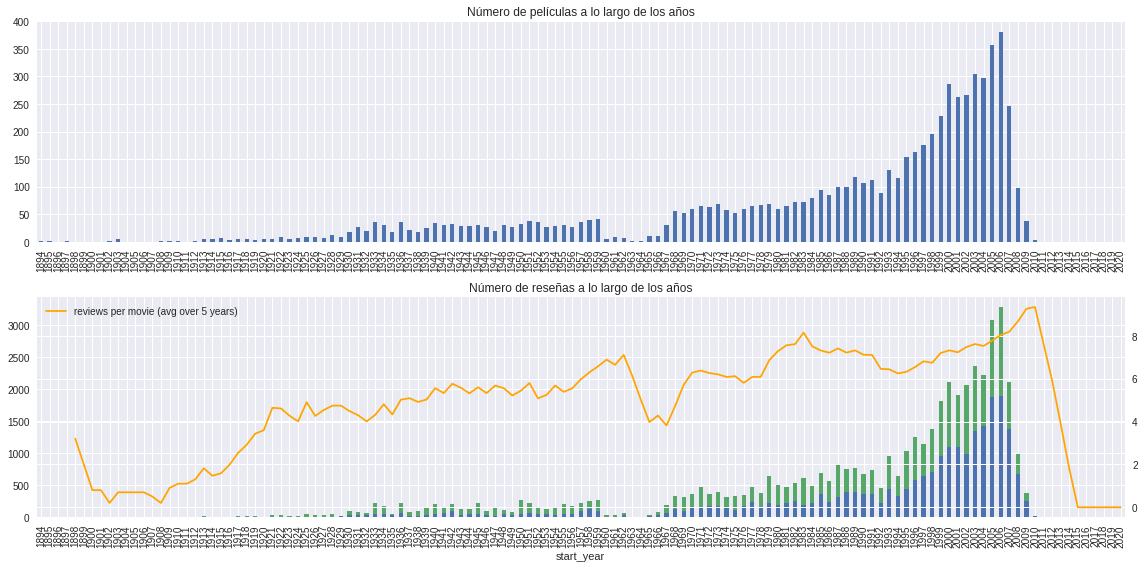

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

In [18]:
df_reviews.query('start_year >= 1990')["start_year"].value_counts(normalize=True)

2006    0.106855
2005    0.100362
2003    0.076838
2004    0.072694
2000    0.068779
2007    0.068713
2002    0.067572
2001    0.062384
1999    0.059154
1998    0.044993
1996    0.040915
1997    0.037424
1995    0.033672
2008    0.032334
1993    0.031322
1991    0.024242
1990    0.022056
1994    0.021273
1992    0.014943
2009    0.012594
2010    0.000881
Name: start_year, dtype: float64

In [19]:
df_reviews.query('start_year <= 1930')["start_year"].value_counts(normalize=True)

1930    0.181982
1928    0.104505
1925    0.099099
1921    0.064865
1927    0.063063
1926    0.057658
1922    0.052252
1929    0.043243
1918    0.039640
1923    0.034234
1924    0.032432
1913    0.032432
1917    0.027027
1919    0.023423
1920    0.021622
1895    0.021622
1915    0.019820
1903    0.018018
1914    0.012613
1909    0.012613
1894    0.010811
1916    0.010811
1897    0.007207
1908    0.003604
1910    0.001802
1902    0.001802
1912    0.001802
Name: start_year, dtype: float64

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

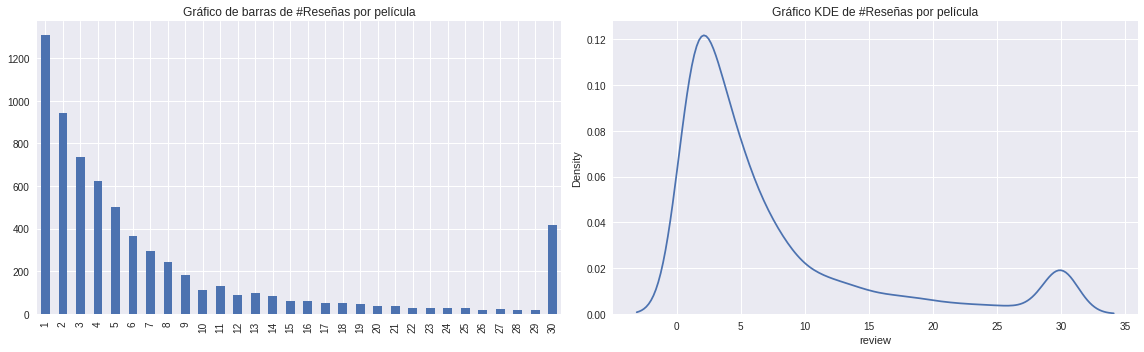

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

De los gráficos anteriores se observa:
1. Hay películas que datan desde 1894 y es apartir de 1930 cuando se observa un incremento en el mundo cinematográfico. Después de 1990 se aprecia que el número de películas superan los 100 y el máximo se obtuvo en el 2006 para luego observar un descenso.
2. La mayor cantidad de reseñas se dan a partir de 1995 que es cuando superan las 1000.
3. Del gráfico de reseñas por película se observa que la mayor cantidad de películas solo tienen 1 reseña y a medida que aumentan la cantidad de reseñas disminuye el número de películas, hasta llegar a 30 reseñas que abarcan un poco más de 400 películas.

In [21]:
df_reviews['pos'].value_counts(normalize=True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

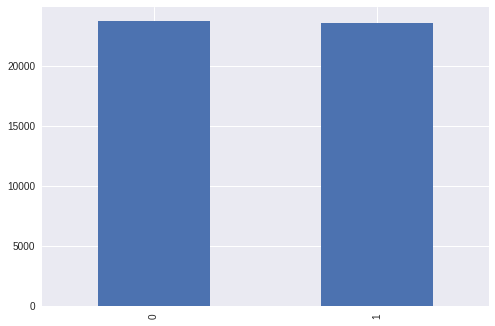

In [22]:
df_reviews['pos'].value_counts().plot(kind="bar")

La distribución de reseñas positivas y negativas son practicamente iguales

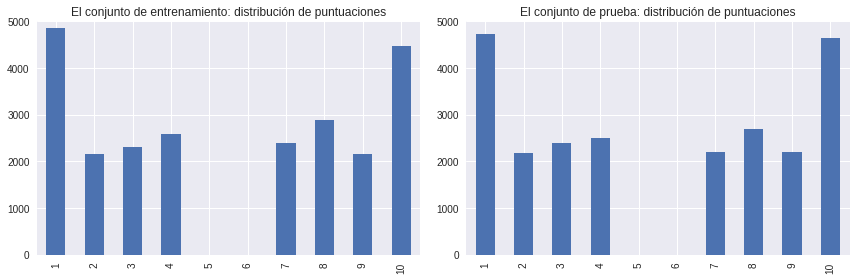

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

La distribución del rating tanto en el conjunto de datos de entranamiento como en el de prueba sigue el mismo comportamiento, encontrándose aproximadamente unas 4900 películas con rating 1 en ambos conjunto de datos y en segunda posición se encuentran las de rating 10 con 4500 películas. No se detectaron películas con rating de 5 y 6.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

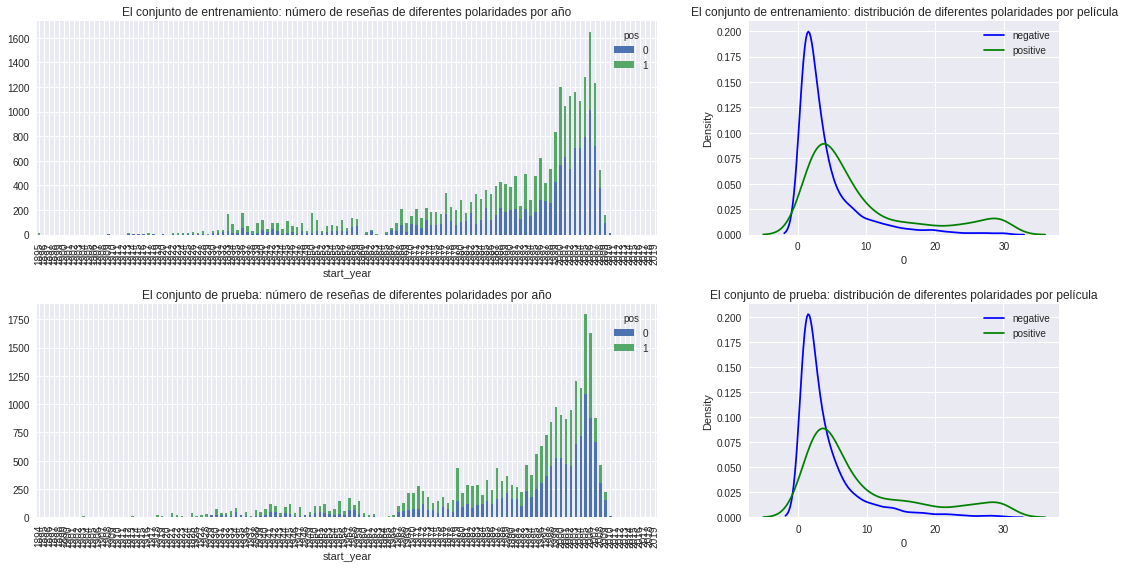

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

In [25]:
df_reviews.query('ds_part=="train"')["pos"].value_counts(normalize=True)

0    0.500588
1    0.499412
Name: pos, dtype: float64

In [26]:
df_reviews.query('ds_part=="test"')["pos"].value_counts(normalize=True)

0    0.501508
1    0.498492
Name: pos, dtype: float64

La mayor densidad de películas con reseñas positivas y negativas se encuntra en los últimos años, es decir, en las películas más recientes y la menor densidad en las películas más viejas, que también representan la minoría de los datos. El comportamiento de las reseñas positivas y negativas, tanto en el conjunto de datos de entrenamiento como de prueba es el mismo.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [27]:

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [28]:
def patron (text):
    pattern = r"[^a-zA-Z']" 
    text = re.sub(pattern, " ", text)
    text = text.split()
    text = " ".join(text)
    return text.lower()

In [29]:
df_reviews['review_norm'] = df_reviews["review"].apply(patron)

In [30]:
df_reviews["review_norm"]

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47331, dtype: object

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [31]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

feature_train = df_reviews_train["review_norm"]
feature_test = df_reviews_test["review_norm"]

print(df_reviews_train.shape)
print(df_reviews_test.shape)
print(feature_train.shape)
print(feature_test.shape)

(23796, 18)
(23535, 18)
(23796,)
(23535,)


## Trabajar con modelos

### Modelo 0 - Constante

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5
          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5
          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


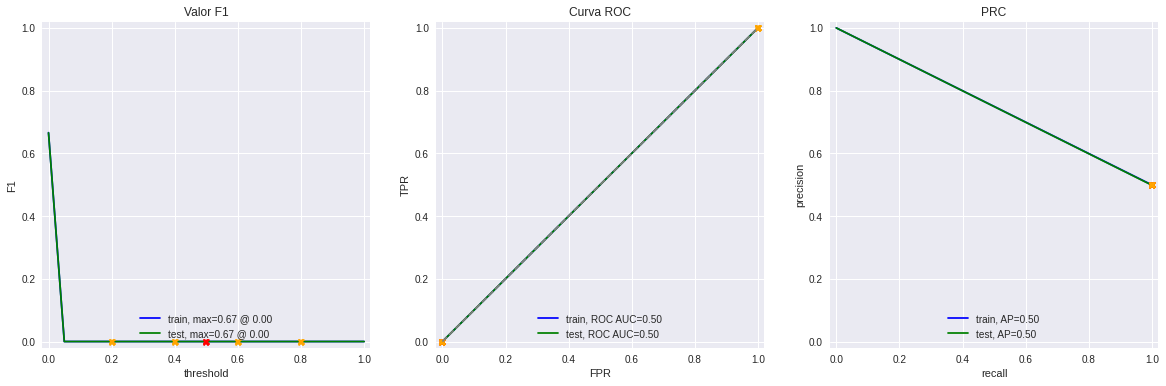

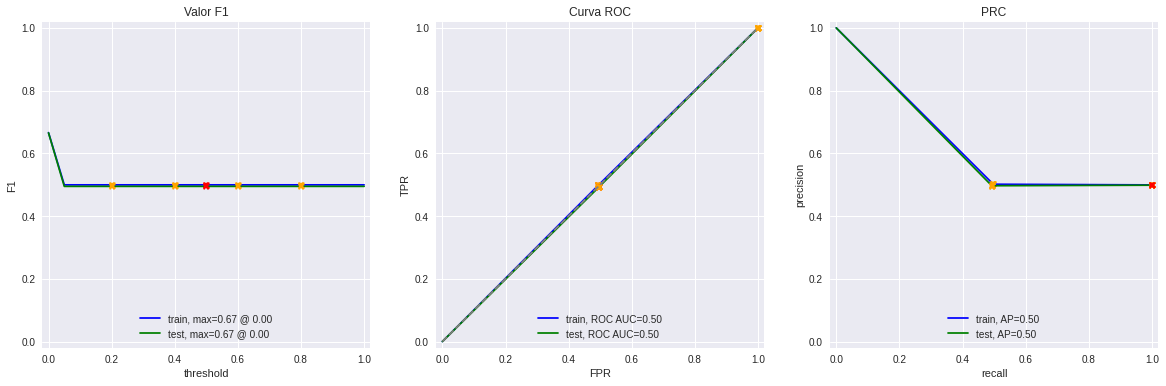

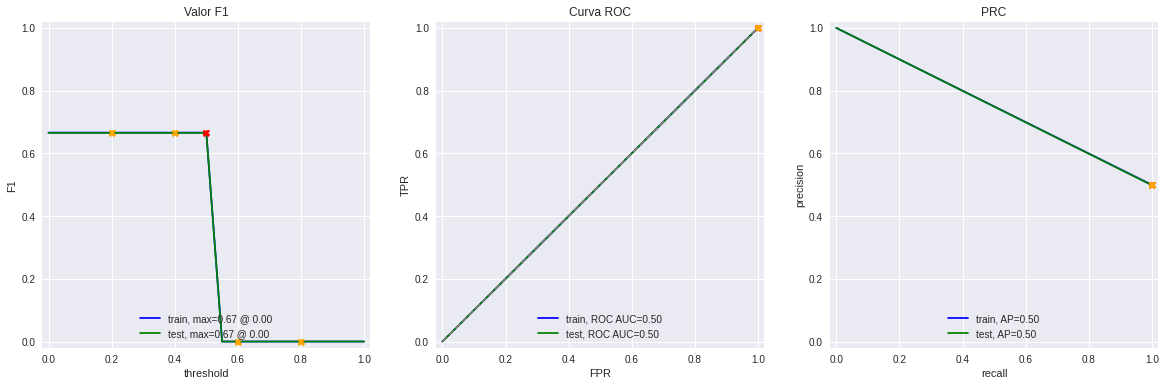

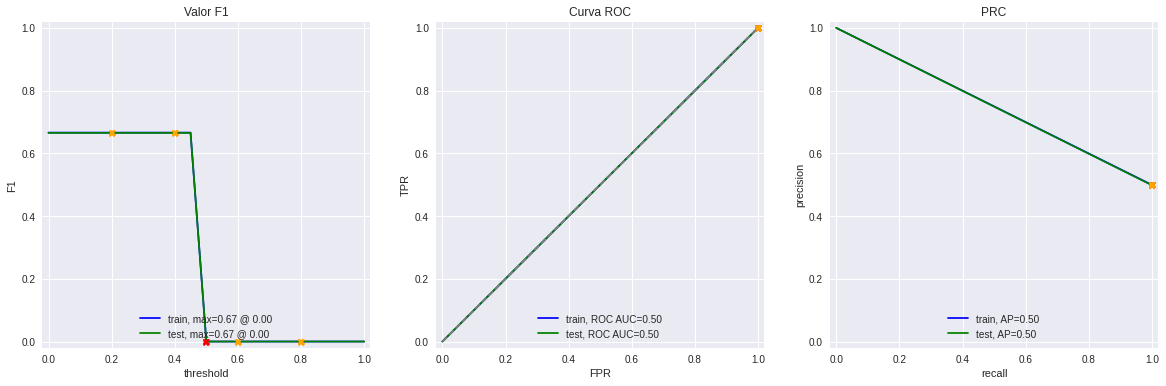

In [32]:
strategy= ["most_frequent", "stratified", "uniform", "prior"]
for i in strategy:
    modelo_d = DummyClassifier(strategy=i)
    modelo_d.fit(feature_train, train_target)
    evaluate_model(modelo_d, feature_train, train_target, feature_test, test_target)
    

De acuerdo al modelo Dummy, la métrica F1 se ve afectada por la estrategia utilizada, mientras que APS y ROC no se afectan. Los valores para F1 promedio varían entre 0 y 0.5 y para las otras métricas es de 0.5. El comportamiento en ambos conjuntos de datos es el mismo. Estos valores resultan consistentes puesto que tanto las reseñas positivas como negativas son prácticamente iguales, es decir, 50%, por lo que asumir que todas son positivas cuando solo la mitad lo es, daría un error aproximado del 50%.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [33]:
#Lematizando los textos
def lematiza_nltk(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    lemmatized = " ".join(lemmas)
    return lemmatized

In [34]:
import nltk
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [35]:
df_reviews_train["reviews_lemma_nltk"] = feature_train.apply(lematiza_nltk)
df_reviews_test["reviews_lemma_nltk"] = feature_test.apply(lematiza_nltk)
df_reviews_train.shape

(23796, 19)

In [36]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
count_tfidf = TfidfVectorizer(stop_words = stop_words)
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)
feature_train_nltk = count_tfidf.fit_transform(df_reviews_train["reviews_lemma_nltk"])
feature_test_nltk = count_tfidf.transform(df_reviews_test["reviews_lemma_nltk"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [37]:
print(feature_train_nltk.shape)
print(feature_test_nltk.shape)

(23796, 64299)
(23535, 64299)


In [38]:
model_1 = LogisticRegression(solver="liblinear", random_state=12345)
model_1.fit(feature_train_nltk, train_target)

LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


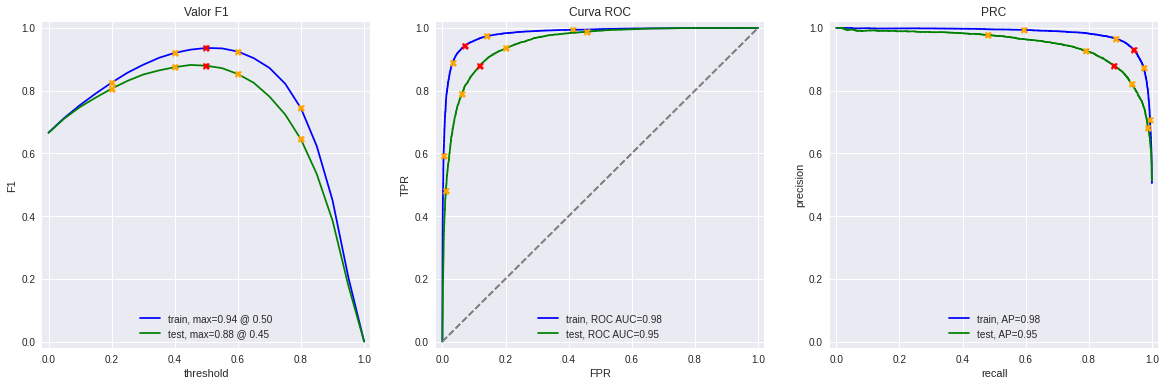

In [39]:
evaluate_model(model_1, feature_train_nltk, train_target, feature_test_nltk, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [40]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [41]:
def lematiza_spacy(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [42]:
df_reviews_train["reviews_lemma_spacy"] = feature_train.apply(lematiza_spacy)
df_reviews_test["reviews_lemma_spacy"] = feature_test.apply(lematiza_spacy)
df_reviews_train.shape

(23796, 20)

In [43]:
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)

feature_train_spacy = tfidf_vectorizer_2.fit_transform(df_reviews_train["reviews_lemma_spacy"])
feature_test_spacy = tfidf_vectorizer_2.transform(df_reviews_test["reviews_lemma_spacy"])
print(feature_train_spacy.shape)
print(feature_test_spacy.shape)

(23796, 59213)
(23535, 59213)


In [44]:
model_2 = LogisticRegression(solver="liblinear", random_state=12345)
model_2.fit(feature_train_spacy, train_target)

LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


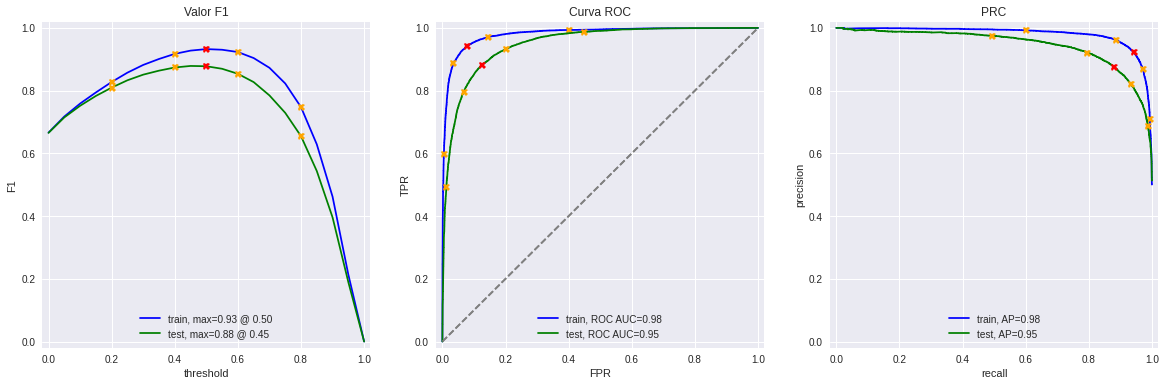

In [45]:
evaluate_model(model_2, feature_train_spacy, train_target, feature_test_spacy, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [46]:
model_3=LGBMClassifier(num_leaves=30,
                      learning_rate=0.5,
                      n_estimators=20,
                      max_depth=10,
                      objective="binary",
                      random_state=12345)
model_3.fit(feature_train_spacy, train_target)

LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=20, num_leaves=30,
               objective='binary', random_state=12345)

          train  test
Accuracy   0.89  0.83
F1         0.89  0.83
APS        0.96  0.91
ROC AUC    0.96  0.91


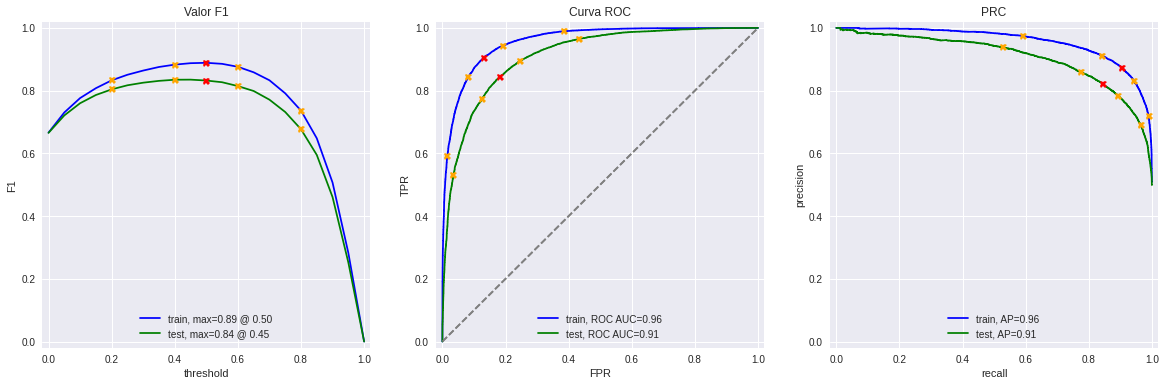

In [47]:
evaluate_model(model_3, feature_train_spacy, train_target, feature_test_spacy, test_target)

###  Modelo 9 - BERT

In [48]:
import torch
import transformers

In [49]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    

    # texto al id de relleno de tokens junto con sus máscaras de atención 
      
             
    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    for input_text in texts[:200]:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, max_length=max_length, truncation=True)
        padded = np.array(ids+[0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0,1,0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [51]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cpu')

Uso del dispositivo cpu.


  0%|          | 0/2 [00:00<?, ?it/s]

In [52]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(200, 768)
(23796,)


In [53]:
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cpu')

Uso del dispositivo cpu.


  0%|          | 0/2 [00:00<?, ?it/s]

In [54]:
len(test_features_9[0])

768

In [55]:
train_target_9 = train_target[:200]
test_target_9 = test_target[:200]
model_9 = LogisticRegression()
model_9.fit(train_features_9, train_target_9)

LogisticRegression()

In [58]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
with np.load('features_9.npz') as data:
     train_features_9 = data['train_features_9']
     test_features_9 = data['test_features_9']

          train  test
Accuracy    1.0  0.79
F1          1.0  0.76
APS         1.0  0.93
ROC AUC     1.0  0.90


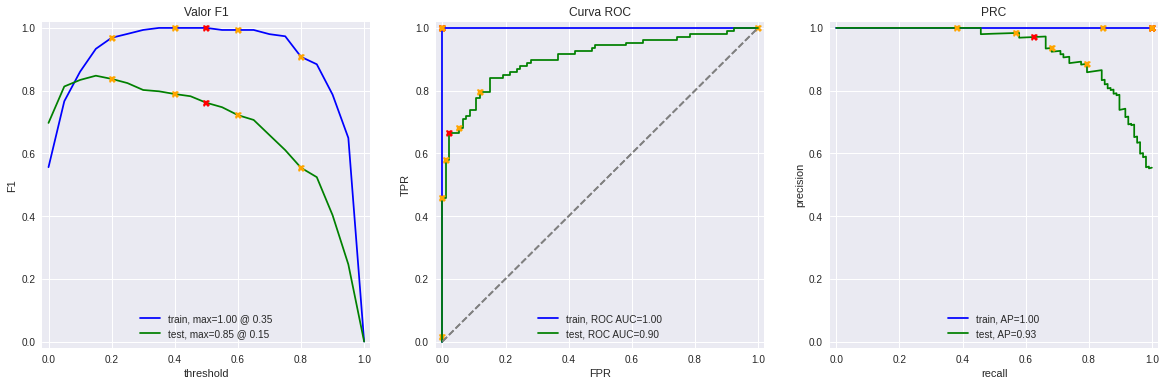

In [59]:
evaluate_model(model_9, train_features_9, train_target_9, test_features_9, test_target_9)

## Mis reseñas

In [60]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews["review"].apply(patron)
my_reviews["pos"] = [0, 0, 1, 0, 1, 1, 0, 1]
my_reviews

,review,review_norm,pos
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,0
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,0
2,I was really fascinated with the movie,i was really fascinated with the movie,1
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...,1
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,1
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,0
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...,1


### Modelo 1

In [61]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie
0.22:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.33:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.46:  i didn't expect the reboot to be so good writers really cared about the source material
0.46:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [62]:
mean_squared_error(my_reviews_pred_prob[:13], my_reviews['pos'])**0.5

0.36524298235558295

### Modelo 2

In [63]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: lematiza_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didn't expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [64]:
mean_squared_error(my_reviews_pred_prob, my_reviews['pos'])**0.5

0.3805876828358017

### Modelo 3

In [65]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = tfidf_vectorizer_2
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: lematiza_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.62:  i did not simply like it not my kind of movie
0.64:  well i was bored and felt asleep in the middle of the movie
0.62:  i was really fascinated with the movie
0.45:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.71:  i didn't expect the reboot to be so good writers really cared about the source material
0.69:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.42:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.77:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [66]:
mean_squared_error(my_reviews_pred_prob, my_reviews['pos'])**0.5

0.439454121718909

### Modelo 9

In [67]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.02:  i did not simply like it not my kind of movie
0.00:  well i was bored and felt asleep in the middle of the movie
0.04:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.00:  i didn't expect the reboot to be so good writers really cared about the source material
0.12:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.50:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [68]:
mean_squared_error(my_reviews_pred_prob, my_reviews['pos'])**0.5

0.6054837013559108

## Conclusiones


1. Hay 47331 registros, con 17 columnas, las cuales son del tipo object, int, float.
2. Las columnas de interés son: "reviews", "pos" y "ds_part", ninguna de las 3 tiene datos ausentes. "Reviews" es del tipo object, el target: "pos" es int y "ds_part" es object.
3. Se detectaron 2 datos ausentes en las columnas average_rating y votes.
4. No hay datos duplicados.
5. La columna "start_year" muestra un mínimo de 1894, dato curioso por lo antiguo de esa película.
6. La columna "pos" tiene una media muy por encima de la mediana, es decir hay una asimetría positiva.
7. Casi todas las películas están dentro de la clasificación de no adultos.
8. El modelo de regresión logística con NLTK y Spacy fue el que mayor exactitud tuvo para la muestra de prueba, seguido por LGBM, igual resultado se obtuvo con my reseña, donde el menor error encontrado fue con los 2 modelos antes mencionado.
9. El modelo Dummy y Bert fueron los que menos ajustaron la muestra de prueba, reportando 0.5 y 0.79 de exactitud y 0.5 y 0.76 de F1, así como en el error cuadrático medio en mi reseña Bert obtuvo el mayor valor de 0.6.

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código 
- [ ]  Hay conclusiones 